# Курс по машинному обучению,   ВМК МГУ
## Линейные модели классификации и регрессии

### Важно! О формате сдачи

* **Все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

### Важно!

**Перед тем, как сдать ноутбук на кросс-рецензирование, мы рекомендуем перезапустить ядро и выполнить весь ноутбук (cell -> run all). При правильном выполнении весь процесс работы ноутбука не должен занять больше 20 минут**

__Цель данного задания:__

- Узнать, что такое переобучение и как с ним бороться в линейных моделях;
- Научиться работать с разными типами признаков;
- Понять, чем отличаются разные регуляризаторы;
- Приятно провести осенний вечер, предсказывая дождь.

При выполнении данного задания необходимо последовательно запустить все ячейки ноутбука и ответить на $20$ вопросов. Ответы на вопросы будут проверены в рамках кросс-ревью. Всего за ответы на вопросы можно получить  25  баллов.

**А также..**

Если в ячейке написана фраза "Ваш ответ здесь", то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Ваш код здесь", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Ваш ответ здесь", и ячейка с фразой "Ваш код здесь", то в ответе ожидается и код, и текст)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
%matplotlib inline

**Юнит-тесты**

Здесь импортируются классы, которые необходимо реализовать самостоятельно. Подробное описание того, что необходимо реализовать вы можете найти в pdf задания. Правильность реализации проверяется юнит-тестами. Максимально за юнит-тесты можно получить  20  баллов. Шаблон решения находится во вкладке "Linear models (unit-tests)" в "шаблоне решения".

In [2]:
from Task import MyOneHotEncoder, SimpleCounterEncoder, FoldCounters

### Часть 1. Линейная регрессия

Напомним, что линейная регрессия — это модель следующего вида: $$a(x) = \langle w, x \rangle + b$$ где $w \in \mathbb{R}^d$, $b \in \mathbb{R}$. Обучить линейную регрессию — значит найти $w$ и $b$.

Для обучения линейной регрессии, равно как и для обучения остальных простых моделей (линейные модели, решающие деревья, knn и т.д.) отлично подходит библиотека scikit-learn (sklearn): в ней очень понятный и простой интерфейс.

Однако для обучения более сложных моделей вроде бустинга и нейронных сетей всё же нужно пользоваться специализированными библиотеками: XGBoost, LightGBM, CatBoost и пр. для градиентного бустинга над деревьями, PyTorch, Tensorflow и пр. для нейронных сетей. 

Так как мы будем обучать линейную регрессию, нам подойдет реализация из sklearn. В sklearn есть несколько классов, реализующих линейную регрессию. Основные это:

- Ridge — линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
- Lasso — линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Также есть SVR, ElasticNet  и пр., но не будем сегодня о них

У моделей из sklearn есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке.

Рассмотрим, модельные данные для задачи регрессии. Пусть $x$ будет обычным числом из равномерного распределения, а $y = 0.5 \cdot x + 0.1$ &mdash; целевая переменная. При этом наблюдаем мы $\overline{y} = y + \varepsilon,~\varepsilon \sim \mathcal{N}(0, 0.01)$.

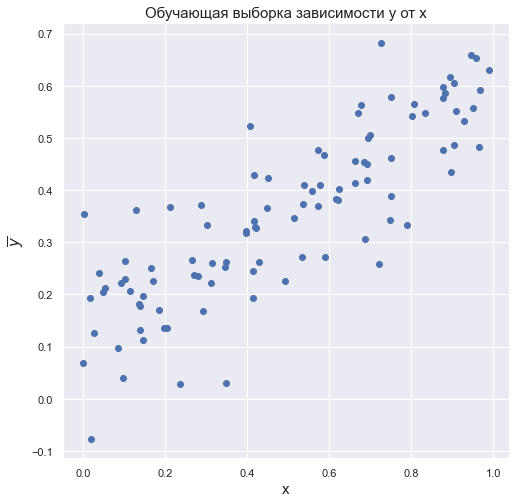

In [3]:
np.random.seed(1)
X = np.random.uniform(0, 1, 100)
Y = X * 0.5 + 0.1 + np.random.randn(100) * 0.1

plt.figure(figsize=(8, 8))
plt.scatter(X, Y)
plt.title("Обучающая выборка зависимости y от x", size=15)
plt.xlabel("x", size=15)
plt.ylabel(r'$\overline{y}$', size=15)
plt.show()

Обучим линейную регрессию, и посмотрим как регуляризация влияет на качество модели. В реализации библиотеки sklearn коэффициент регуляризации задаётся параметром alpha

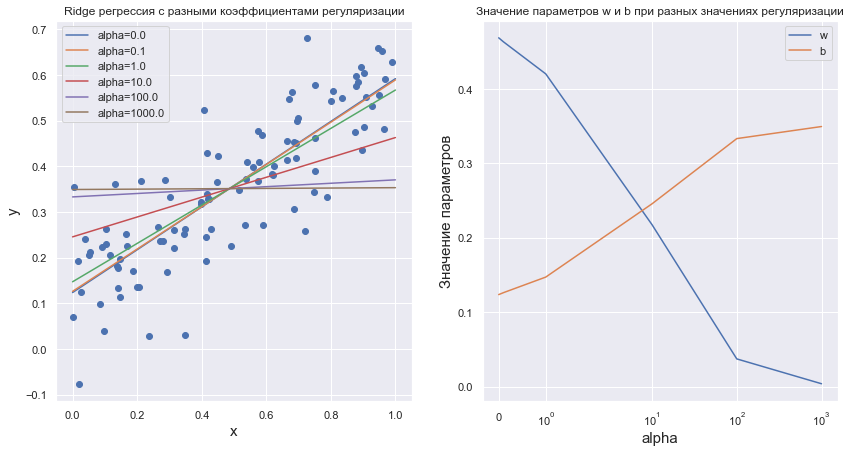

In [4]:
from sklearn.linear_model import Ridge

x_axis = np.linspace(0, 1, 200)
fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].scatter(X, Y)

w = []
b = []

alphas = [0.0, 0.1, 1.0, 10.0, 100.0, 1000.0]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X[:, None], Y)
    pred = reg.predict(x_axis[:, None])
    w.append(reg.coef_[0])
    b.append(reg.intercept_)
    axs[0].plot(x_axis, pred, label="alpha=" + str(alpha))

axs[0].legend()
axs[0].set_xlabel("x", size=15)
axs[0].set_ylabel("y", size=15)
axs[0].set_title("Ridge регрессия с разными коэффициентами регуляризации")
axs[1].plot(alphas, w, label="w")
axs[1].plot(alphas, b, label="b")
axs[1].set_xlabel("alpha", size=15)
axs[1].set_ylabel("Значение параметров", size=15)
axs[1].set_title("Значение параметров w и b при разных значениях регуляризации")
axs[1].set_xscale("symlog", linthreshy=0.01)
axs[1].legend()
plt.show()

**Вопрос 1** ($1$ балл): Как зависят параметры модели от константы регуляризации? А качество?

С ростом константы регуляризации веса модели w уменьшаются, становясь практически нулевыми при очень больших значениях альфа.  
Точность модели падает, так как наиболее близкие значения (w, b) к (0.5, 0.1) получились именно при альфа = 0.  
Значение b растет, но изменения происходят намного медленнее, чем в случае с w.

**Вопрос 2** ($1$ балл): Почему при обучении линейных моделей, коэффициент $b$ не регуляризуется? Дайте ответ с опорой на лекции и увиденные картинки.

Регуляризация помогает избавиться от больших по модулю весов, которые при умножении на признаки могут приводить к значительным ошибкам даже из-за небольшого шума, а также это может привести к переобучению. Однако коэффициент b не умножается на признак, следовательно, его большие значения не приведут к описанным негативным последствиям.

Казалось бы, зачем нам эта глупая регуляризация?! 

Давайте рассмотрим ещё один модельный пример. Представим, что кто-то добавил в данные к переменной $x$ её же умноженную на $2$. То есть, теперь у нас два признака $x_1$ и $x_2 = 2 \cdot x_1$. Тогда, $y = c \cdot 0.5 \cdot x_1 + \frac{c - 1}{4} \cdot x_2 + 0.1$, где $c$ любое сколь угодно большое вещественное число. Это может привести к тому, что без регуляризации мы рискуем выучить очень большие веса!

In [5]:
np.random.seed(1)
X2 = np.hstack((X[:, None], 2 * X[:, None]))
Y2 = X2[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X2, Y2)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 0.1006220738265918 	w2: 0.20124414765318363


Коэффициенты адекватные, хотя и не похожи на изначальную зависимость. Но что, если $x_2$ будет равняться $3 \cdot x_1$?

In [6]:
np.random.seed(1)
X3 = np.hstack((X[:, None], 3 * X[:, None]))
Y3 = X3[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X3, Y3)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 20003143166886.305 	w2: -6667714388961.933


Тут вот уже не повезло. Коэффициенты случайно выучились неадекватно большими. Создадим обучающую выборку из того же распределения и посмотрим на качество

In [7]:
np.random.seed(2)
X3_test = np.random.uniform(0, 1, 100)
X3_test = np.hstack((X3_test[:, None], 3 * X3_test[:, None]))
Y3_test = X3_test[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

Y3_test_pred = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss: %.4f" % np.mean((Y3_test_pred - Y3_test) ** 2))

MSE loss: 0.0202


Вроде бы неплохое, но что если мы добавим ко второму признаку одного из объектов небольшой шум?

In [8]:
X3_test[0, 1] = X3_test[0, 1] + 1e-10
Y3_test_pred_noisy = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss:", np.mean((Y3_test_pred_noisy - Y3_test) ** 2))
print("Предсказание для первого объекта с шумом: ", Y3_test_pred_noisy[0])
print("Предсказание для первого объекта без шума: ", Y3_test_pred[0])

MSE loss: 4443.952144116807
Предсказание для первого объекта с шумом:  -666.3564453125
Предсказание для первого объекта без шума:  0.4150390625


Как видим, даже небольшое изменение в данных, приводит к резкому падению качества.

**Вопрос 3** ($1$ балл): Рассмотрите больше примеров с двумя признаками $x_1$ и $x_2$, где $x_2$ линейно зависит от $x_1$. Убедитесь, что линейная модель без регуляризации крайне неустойчива.

In [9]:
np.random.seed(22)
x = np.random.uniform(0, 1, 100)
x_1 = np.hstack((x[:, None], 1.8 * x[:, None]))
y_1 = x_1[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1
reg = Ridge(alpha=0.0)
reg.fit(x_1, y_1)
print("w1:", reg.coef_[0], "w2:", reg.coef_[1])
np.random.seed(2)

w1: 11452014792626.604 w2: -6362230440347.871


Веса больше триллиона по модулю - это очень неустойчиво :(

Теперь добавим регуляризацию и посмотрим, как меняются значения весов в зависимости от значения коэффициента регуляризации.

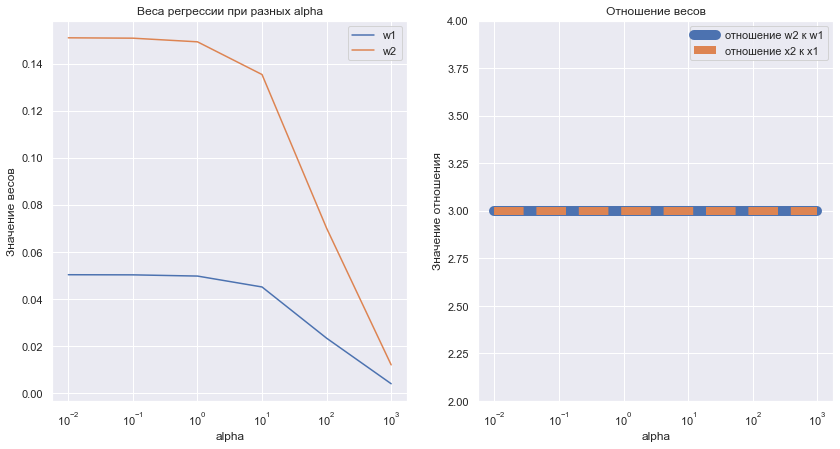

In [10]:
w1 = []
w2 = []

alphas = [0.01, 0.1, 1, 10, 100, 1000]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X3, Y3)
    w1.append(reg.coef_[0])
    w2.append(reg.coef_[1])
    
w1 = np.array(w1)
w2 = np.array(w2)

fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].plot(alphas, w1, label="w1")
axs[0].plot(alphas, w2, label="w2")
axs[0].set_xscale("log")
axs[0].set_title("Веса регрессии при разных alpha")
axs[0].set_xlabel("alpha")
axs[0].set_ylabel("Значение весов")
axs[0].legend()
axs[1].plot(alphas, w2 / w1, label="отношение w2 к w1", linewidth=10)
axs[1].plot([0.01, 1000], [3, 3], label="отношение x2 к x1", linestyle="--", linewidth=8)
axs[1].set_xscale("log")
axs[1].set_ylim(2,4)
axs[1].set_xlabel("alpha")
axs[1].set_ylabel("Значение отношения")
axs[1].set_title("Отношение весов")
axs[1].legend()
plt.show()

**Вопрос 4** ($2$ балла): Как думаете, почему отношение между весами постоянно?

(подсказка, необходимо выписать функцию потерь и посчитать производные по весам)

Производная по $w_{j}$ равна  $2\sum\limits_{i = 1}^{l}(y_{i} - <x_{i}, w>)(-x_{i}^{j}) + 2\alpha w_{j}$
  
С изменением $\alpha$ функция потерь одинаково изменяется для всех весов, так как $\alpha$ и $w$ входят в производную линейно, следовательно от значения $\alpha$ изменяется значение суммы, которая умножается на альфа, но не значение слагаемых в этой сумме относительно друг друга.

Заметим, что при $l_2$ регуляризации в данном примере веса получились пропорциональны значениям признаков. При этом, мы знаем, что оба признака взаимно однозначны, и прогноз можно делать только по одному из них. Для этого придумана $l_1$ регуляризация. В билиотеке sklearn линейная регрессия с $l_1$ регуляризацией реализована в классе Lasso

**Вопрос 5** (2 балла): Почему в нашем примере $l_1$ регуляризация приведёт к разреживанию весов?

(подсказка, нужно опять подсчитать производную, но обратите внимание на дифференцируемость модуля)

Производная по $w_{j}$ равна  $2\sum\limits_{i = 1}^{l}(y_{i} - <x_{i}, w>)(-x_{i}^{j}) +\alpha sgn(w_{j}), w_{j} <> 0$  
  
Если значение $\alpha$ достаточно велико, модель приравняет такой вес $w_{i}$ к нулю.  
В точке $w_{j} = 0$ нет ничего плохого, так как регуляризация должна уменьшать веса, и, очевидно, она не может уменьшить вес, уже равный 0.

Добавим  $l_1$  регуляризацию и посмотрим, как меняются значения весов в зависимости от значения коэффициента регуляризации.

In [11]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=1.)
reg.fit(X3, Y3)
print("Веса, при alpha = 1.")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.1)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.1")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.01)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.01")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.001)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.0001)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.0001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.00001)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.00001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

Веса, при alpha = 1.
w1: 0.0 	w2: 0.0

Веса, при alpha = 0.1
w1: 0.0 	w2: 0.039506627863033

Веса, при alpha = 0.01
w1: 0.0 	w2: 0.154883773526191

Веса, при alpha = 0.001
w1: 0.0 	w2: 0.1664214880925068

Веса, при alpha = 0.0001
w1: 0.0 	w2: 0.16757525954913843

Веса, при alpha = 0.00001
w1: 0.4261538129756493 	w2: 0.025639365702918863



**Вопрос 6** ($2$ балла): Почему в итоге при $\alpha = 0.00001$ получились веса не равные нулю?

Ответ: по умолчанию число итераций равно 1000, но при малом коэффициенте альфа алгоритм сходится медленнее, следовательно, ему просто не хватило итераций, чтоб обнулить w0. Это можно проверить, поставив максимальное число итераций 10,000. Видно, что w0 обнуляется, как и при других значениях альфа, но требуется 6542 итерации для сходимости.

In [12]:
reg = Lasso(alpha=0.00001)
reg.fit(X3, Y3)
print("alpha = 0.00001, max_iter=1000\nЧисло итераций:", reg.n_iter_)
print("Веса:")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.00001, max_iter=10000)
reg.fit(X3, Y3)
print("alpha = 0.00001, max_iter=10000\nЧисло итераций:", reg.n_iter_)
print("Веса:")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

alpha = 0.00001, max_iter=1000
Число итераций: 1000
Веса:
w1: 0.4261538129756493 	w2: 0.025639365702918863

alpha = 0.00001, max_iter=10000
Число итераций: 6542
Веса:
w1: 0.0 	w2: 0.1676906366948018


Попробуем обучить линейную регрессию на специальном датасете из sklearn

In [13]:
from sklearn.datasets import fetch_california_housing

In [14]:
X, y = fetch_california_housing(return_X_y=True)
X_train, y_train, X_test, y_test = X[:10000], y[:10000], X[10000:], y[10000:]

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
reg = Lasso(alpha=0.1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Test MSE = 0.6847


Проанализируем ошибку на обучающей выборке.

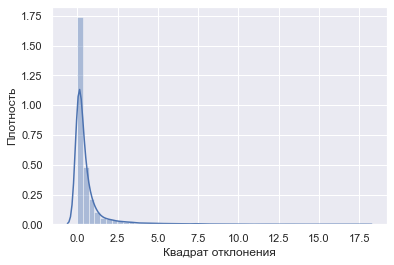

In [17]:
error = (y_train - reg.predict(X_train)) ** 2
sns.distplot(error)
plt.xlabel("Квадрат отклонения")
plt.ylabel("Плотность")
plt.show()

Как видно, есть несколько объектов, на которых модель ошибается сильно. Давайте удалим их из обучающей выборки.

In [18]:
mask = (error < np.quantile(error, 0.99))
reg.fit(X_train[mask], y_train[mask])
y_pred = reg.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))

Test RMSE = 0.6756


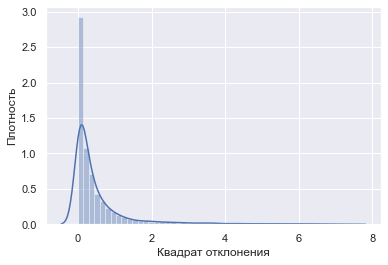

In [19]:
error = (y_train[mask] - reg.predict(X_train[mask])) ** 2
sns.distplot(error)
plt.xlabel("Квадрат отклонения")
plt.ylabel("Плотность")
plt.show()

Таким образом, можно улучшить качество линейной регрессии, если удалить из обучающей выборки выбросы. В данном примере качество улучшилось не так сильно, но бывают ситуации, когда чистка обучающей выборки по квадратичной ошибке, приводит к сильному улучшению качества.

Также обратим внимание, на веса модели. Часть из них занулилось. Это большое преимущество, так как разреживание весов позволяет отбирать нужные признаки, делая модель более лёгкой.

In [20]:
reg.coef_

array([ 4.02918974e-01,  1.28178142e-02, -0.00000000e+00,  0.00000000e+00,
        4.53555975e-05, -6.81173164e-03, -7.58947693e-02, -0.00000000e+00])

А теперь обучим с  $l_2$  регуляризацией.

In [21]:
reg = Ridge(alpha=1)
reg.fit(X_train, y_train)
print(reg.coef_)

[ 4.51549218e-01  5.12533532e-03 -1.19136586e-01  6.66014972e-01
 -5.48001331e-06 -7.24339954e-03 -4.43125173e-01 -3.91587744e-01]


Как видим, веса не разрежены, хотя и есть очень маленькие значения

**Вопрос 7** (2 балла): Приведите пример, когда линейная регрессия с $l_2$ регуляризацией гарантированно занулит какой-нибудь признак?

Когда целевая функция является константой, равной нулю.

### Часть 2. Классификация

Напомним, что бинарная линейная классификация с классами $0$ и $1$ &mdash; это модель следующего вида:
$a(x)= \begin{cases}
1, & \langle w, x \rangle + b > 0; \\
0, & \text{иначе.}
\end{cases}$
 
где  $w \in \mathbb{R}^d$,  $b \in \mathbb{R}$. В логистической регрессии $p(x) = \frac{1}{1 + e^{-a(x)}}$ интерпретируется как вероятность принадлежности к первому классу. Если объект $x$ принадлежит классу $1$ с вероятностью $p(x)$, то правдоподобие записывается в виде $\prod_{i=1}^{n} p(x_i)^{y_i} \cdot \left( 1 - p(x_i) \right)^{1 - y_i}$. Обучить логистическую регрессию означает найти параметры $w$ и $b$, которые максимизируют указанное правдоподобие. Что эквивалентно минимизации $- \sum_{i=1}^n y_i \log p(x_i) + (1 - y_i) \log (1 - p(x_i))$. Указанная функция потерь называется логистической (или логлосс), и она минимизируется по $w$ и $b$.

По тем же причинам, что и в линейной регрессии, к логистической функции потерь добавляется регуляризация (стандартно это $l_2$).

Рассмотрим пару модельных примеров, в которых целевая переменная $y$ линейно зависит от двух независимых величин $x_1$ и $x_2$, плюс случайный шум.

In [22]:
np.random.seed(1)
X = np.random.randn(100, 2)
Y = np.random.randn(100) * 1. + X[:, 0] * 3 - X[:, 1] * 0.12
Y = np.where(Y > 0, 1, 0)

Обучим логистическую регрессию, двумя методами LBFGS (https://www.ams.org/journals/mcom/1980-35-151/S0025-5718-1980-0572855-7/S0025-5718-1980-0572855-7.pdf) и Newton-CG (https://arxiv.org/abs/1803.02924). Со статьями по ссылкам можно ознакомиться, но это необязательно для выполнения задания (никто вас не осудит, если вы это не сделаете). Для простоты восприятия, можно считать, что первый похож на градиентный спуск, а второй на метод Ньютона.

In [23]:
from sklearn.linear_model import LogisticRegression

clf_lbfgs = LogisticRegression(C=1, solver='lbfgs', max_iter=1, warm_start=True, fit_intercept=False)
clf_newton_cg = LogisticRegression(C=1, solver='newton-cg', max_iter=1, warm_start=True, fit_intercept=False)

coefs_lbfgs = []
coefs_nc = []

for it in range(1000):
    clf_lbfgs.fit(X, Y)
    coefs_lbfgs.append(clf_lbfgs.coef_[0])
    clf_newton_cg.fit(X, Y)
    coefs_nc.append(clf_newton_cg.coef_[0])
    
coefs_lbfgs = np.array(coefs_lbfgs)
coefs_nc = np.array(coefs_nc)

In [24]:
x1 = np.linspace(0.5, 3.5, 1000)
x2 = np.linspace(-0.5, -0.1, 1000)
X1, X2 = np.meshgrid(x1, x2)

def loss(X1, X2, X, Y):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    p = sigmoid(X1[None] * X[:, 0, None, None] + X2[None] * X[:, 1, None, None]) # 100, 200, 200
    return -np.sum(Y[:, None, None] * np.log(p) + (1 - Y[:, None, None]) * np.log(1 - p), axis=0) + 0.5 * (X1**2 + X2**2)

Z = loss(X1, X2, X, Y)

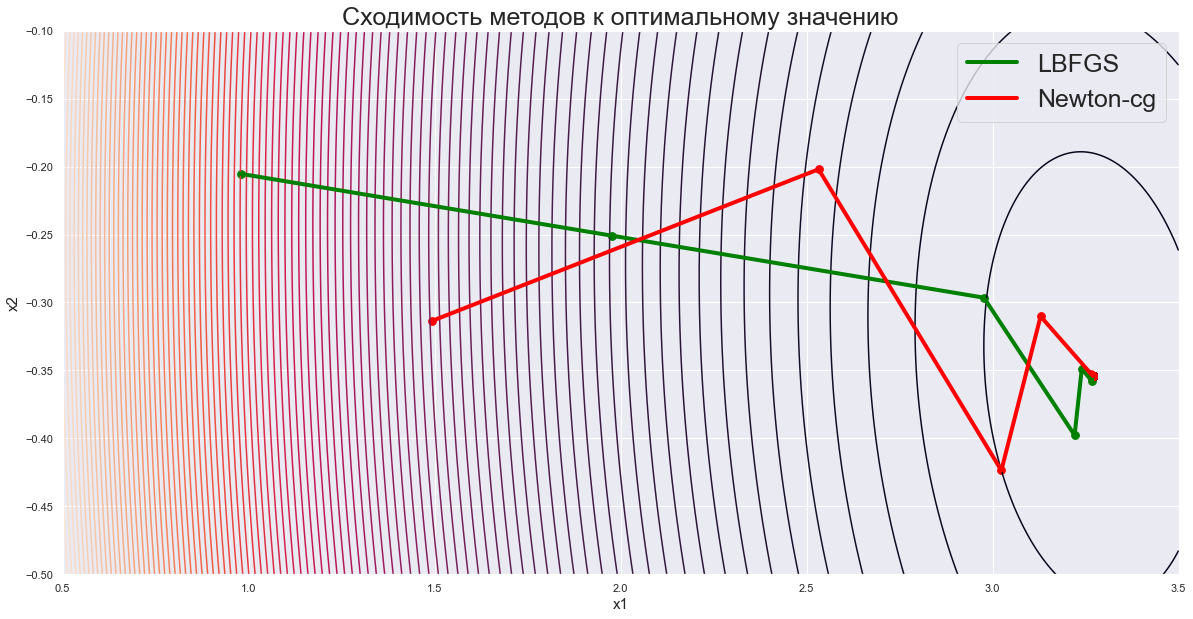

In [25]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))
plt.contour(X1, X2, Z, levels=100)
plt.plot(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", linewidth=4, label="LBFGS")
plt.scatter(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", s=60)
plt.plot(coefs_nc[:, 0], coefs_nc[:, 1], color="red", linewidth=4, label="Newton-cg")
plt.scatter(coefs_nc[:, 0], coefs_nc[:, 1], color="red", s=60)
plt.legend(fontsize=25)
plt.xlabel("x1", size=15)
plt.ylabel("x2", size=15)
plt.title("Сходимость методов к оптимальному значению", size=25)
plt.show()

Рассмотрим второй пример. Внимание, здесь $x_2$ уже из другого распределения! 

In [26]:
np.random.seed(1)
X = np.hstack((np.random.randn(100, 1), np.random.uniform(7, 12, (100, 1))))
Y = np.random.randn(100) * 1. + X[:, 0] * 3 - X[:, 1] * 0.12
Y = np.where(Y > 0, 1, 0)

In [27]:
clf_lbfgs = LogisticRegression(C=1, solver='lbfgs', max_iter=1, warm_start=True, fit_intercept=False)
clf_newton_cg = LogisticRegression(C=1, solver='newton-cg', max_iter=1, warm_start=True, fit_intercept=False)

coefs_lbfgs = []
coefs_nc = []

for it in range(1000):
    clf_lbfgs.fit(X, Y)
    coefs_lbfgs.append(clf_lbfgs.coef_[0])
    clf_newton_cg.fit(X, Y)
    coefs_nc.append(clf_newton_cg.coef_[0])
    
coefs_lbfgs = np.array(coefs_lbfgs)
coefs_nc = np.array(coefs_nc)

x1 = np.linspace(0, 3.5, 1000)
x2 = np.linspace(0.01, -0.1, 1000)
X1, X2 = np.meshgrid(x1, x2)
Z = loss(X1, X2, X, Y)

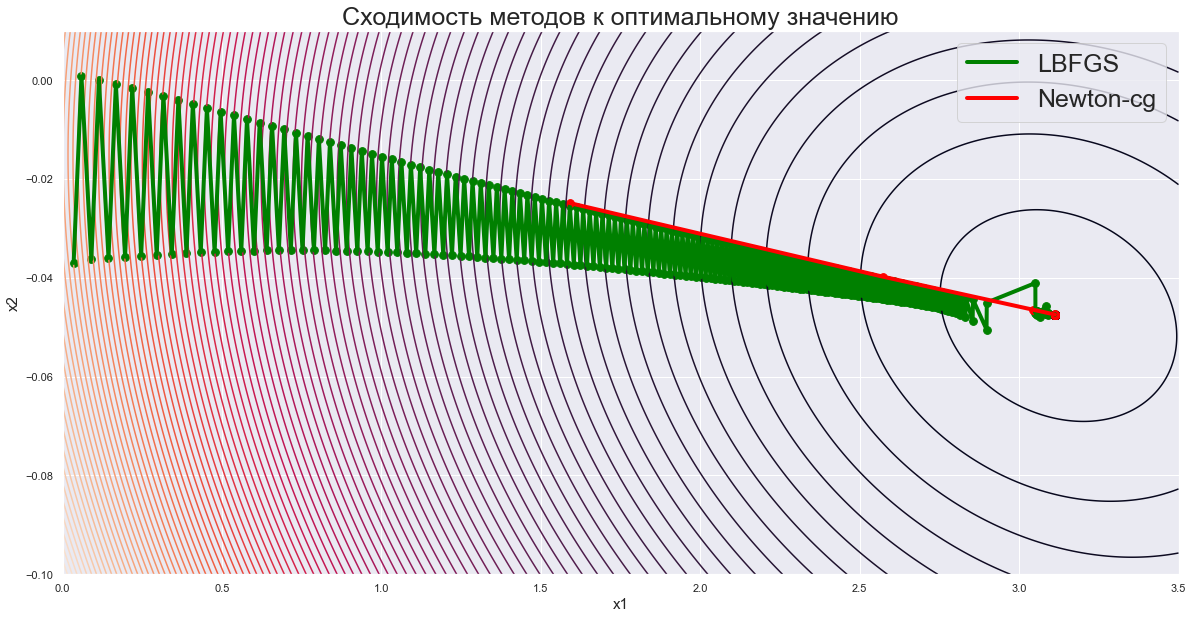

In [28]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))
plt.contour(X1, X2, Z, levels=100)
plt.plot(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", linewidth=4, label="LBFGS")
plt.scatter(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", s=60)
plt.plot(coefs_nc[:, 0], coefs_nc[:, 1], color="red", linewidth=4, label="Newton-cg")
plt.scatter(coefs_nc[:, 0], coefs_nc[:, 1], color="red", s=60)
plt.legend(fontsize=25)
plt.xlabel("x1", size=15)
plt.ylabel("x2", size=15)
plt.title("Сходимость методов к оптимальному значению", size=25)
plt.show()

**Вопрос 8** ($1$ балл): Как видим, метод L-BFGS плохо работает на неотмасштабированных данных. Это общее свойство всех методов первого порядка (т.е. использующих только первую производную). Ньютоновские же методы хорошо справляются с подобными ситуациями. В таком случае, почему LBFGS является методом по умолчанию, а не Newton-CG?

Для нахождения решения необходимо вычислить градиент и гессиан. Newton-CG вычисляет обратный гессиан явно, это требует значительных затрат по времени, а L-BFGS вычисляет приближение к гессиану, что намного быстрее. Таким образом, для квадратичных функций Ньютон-CG сходится быстрее, а L-BFGS сходится быстрее для неквадратичных функций, то есть в общем случае.

#### Обучение на реальных данных

Рассмотрим набор данных от метеорологической службы одной страны. В нём требуется предсказать, будет ли дождь на следующий день. Данные лежат в "Linear models (unit-tests)" в "Дополнительные файлы".

In [29]:
df = pd.read_csv("./weatherAUS.csv")
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**Вопрос 9** ($0.5$ балла): Что это за страна? Подсказка: жители этой страны воспользовались бы методом tail вместо head :)

Австралия

Извлечём немного информации из наших данных

In [30]:
df.shape

(145460, 23)

In [31]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

Внимательно приглядимся к столбцам. Напомним, что мы предсказываем значение RainTomorrow. Давайте посмотрим, на этот столбец

In [32]:
df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

Целевая переменная содержит неопределённые значения! Их нужно удалить из всей выборки. Также, переименуем 'Yes' и 'No' в $1$ и $0$.

In [33]:
df = df[df['RainTomorrow'] == df['RainTomorrow']]
df['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

In [34]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1., 'No': 0.})
df['RainToday'] = df['RainToday'].map({'Yes': 1., 'No': 0.})

In [35]:
print(df.shape)

(142193, 23)


Объектов стало чуть-чуть поменьше. Давайте выведем немного информации о них

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

Как видим, у нас есть 17 признаков имеющих вещественные значения (вещественные признаки), и 5 признаков типа object (категориальные признаки). Для них требуется отдельная предобработка. Пока разобьём выборку на обучающую и тестовую.

In [37]:
from sklearn.model_selection import train_test_split

<img src="https://img.devrant.com/devrant/rant/r_2416968_UUKQJ.jpg" width=360 height=760 />

In [38]:
y = df.RainTomorrow
X = df.drop(columns=["RainTomorrow"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [39]:
X_train.shape

(99535, 22)

#### Вещественные признаки

Как вы могли заметить, среди вещественных и категориальных признаков есть пропущенные значения. В случае с вещественными признаками, пропущенные значения заполняют средним, медианой, нулём или даже пытаются предсказывать по другим признакам. Мы заполним медианой

In [40]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_median = numeric_data.median()
numeric_features = numeric_data.columns
X_train = X_train.fillna(numeric_data_median)
X_test = X_test.fillna(numeric_data_median)

In [41]:
len(numeric_features)

17

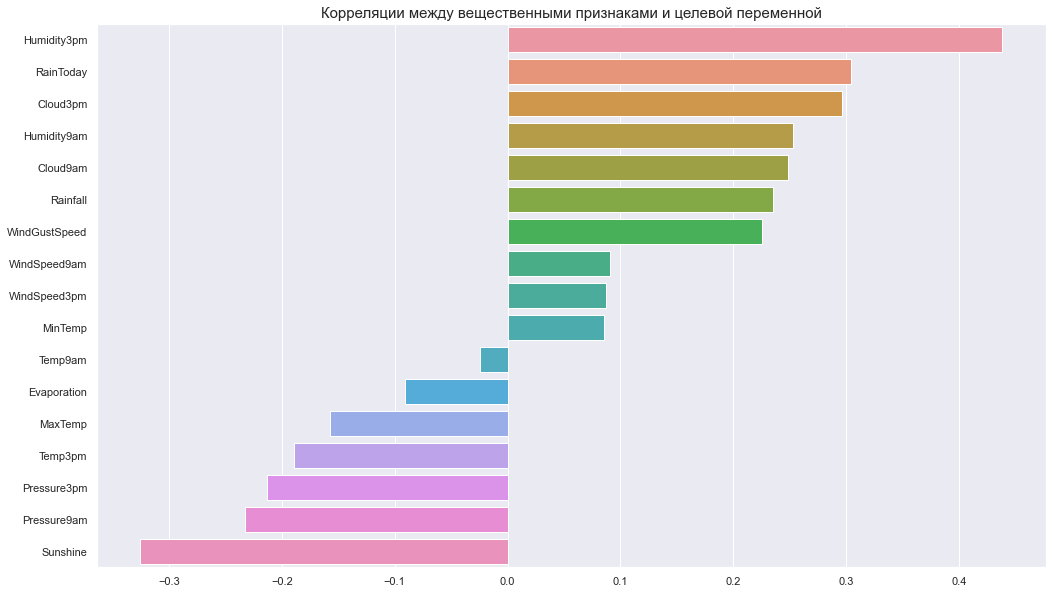

In [42]:
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.set_title("Корреляции между вещественными признаками и целевой переменной", size=15)
plot.figure.set_size_inches(17, 10)

**Вопрос 10** ($1$ балл): Попробуйте объяснить для каких-нибудь признаков получившиеся значения корреляции (почему для одних эти значения высокие, а для других низкие)?

Бывают дождливые периоды и не дождливые, поэтому, если сегодня в 15 часов влажно или идет дождь, то скорее всего дождь будет и завтра, поэтому корреляция между этими признаками и целевой переменной положительная и достаточно обольшая по модулю.  
Также логично, что если сегодня солнечно, то завтра, скорее всего, не будет дождя, поэтому корреляция с этим признаком достаточно велика по модулю, но отрицательна (обратная зависимость).  
Такие данные, как температура или скорость ветра практически не влияют на то, будет ли дождь, поэтому и корреляция для таких данных и целевой переменной близка к нулю.

Дополнительно визуализируем признаки Sunshine и Humidity3pm. Библиотека seaborn предоставляет график swarmplot, который в отличие от scatterplot старается разместить на графике как можно больше точек, так чтобы они не пересекались, уложившись при этом в заданную ширину.

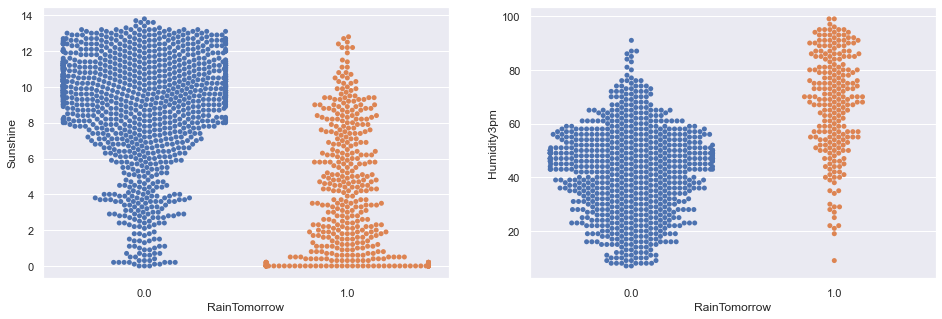

In [43]:
fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
_ = sns.swarmplot(x="RainTomorrow", y="Sunshine", data=df.head(10000), ax=axs[0])
_ = sns.swarmplot(x="RainTomorrow", y="Humidity3pm", data=df.head(1000), ax=axs[1])

Для оценки качества классификации воспользуемся реализованными в sklearn logloss и ROC AUC. ROC AUC является метрикой по умолчанию для бинарной классификации, поскольку очень устойчива к несбалансированности классов. Обучим  логистическую регрессию на вещественных признаках, не подбирая константу регуляризации

In [44]:
from sklearn.metrics import log_loss, roc_auc_score

In [45]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train[numeric_features], y_train)

LogisticRegression(max_iter=1000)

In [46]:
y_pred = model.predict_proba(X_test[numeric_features])[:, 0]
y_train_pred = model.predict_proba(X_train[numeric_features])[:, 0]

print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Train logloss = %.4f" % log_loss(y_train, y_train_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))
print("Train roc auc score = %.4f" % roc_auc_score(y_train, np.where(y_train_pred > 0.5, 0, 1)))

Test logloss = 2.1469
Train logloss = 2.1363
Test roc auc score = 0.7149
Train roc auc score = 0.7110


**Вопрос 11** ($1$ балл): Сколько итераций понадобилось для обучения логистической регрессии?

In [47]:
model.n_iter_

array([528])

Ответ: 528 итераций.

Выведем гистограмму обученных весов

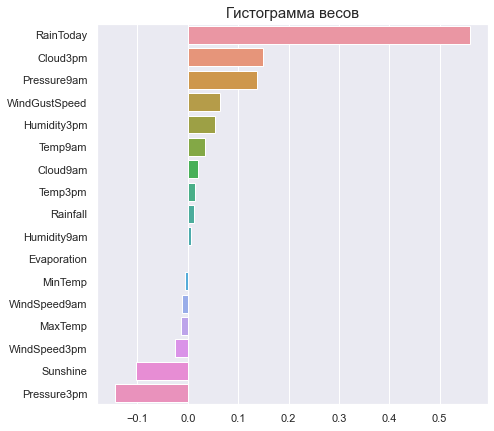

In [48]:
plt.figure(figsize=(7, 7))
sorted_weights = sorted(zip(model.coef_[0], numeric_features), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
_ = sns.barplot(y=features, x=weights).set_title("Гистограмма весов", size=15)

Если приглядеться к весам, то можно увидеть, что между корреляциями признаков с целевой переменной и значениями соответствующих весов мало общего. Чтобы это предотвратить, будем масштабировать наши признаки перед обучением модели. Это, среди прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

In [50]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

**Вопрос 12** ($2$ балла): А сколько итераций потребовалось теперь? Как это связано с модельным примером?

Ответ: 33 итерации. Скорость обучения на данных с нормализацией выше, так как для данных без нормализации в начале намного больший вес имели признаки, численные значения для которых были большие, например данные по давлению (pressure), а некоторые значимые признаки наоборот измерялись в небольших численных значениях (например, cloud), хотя они сильнее влияют на целевую переменную, что видно из корреляций. Таким образом, алгоритму понадобилось значительное число шагов, чтобы вначале сделать эти признаки хотя бы равнозначимыми, а уже потом увеличить веса для облачности по сравнению с весами для давления, тогда как при начальной нормализации данные уже были равнозначимыми.

In [51]:
model.n_iter_

array([33])

In [52]:
y_pred = model.predict_proba(X_test_scaled)[:, 0]
y_train_pred = model.predict_proba(X_train_scaled)[:, 0]

print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Train logloss = %.4f" % log_loss(y_train, y_train_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))
print("Train roc auc score = %.4f" % roc_auc_score(y_train, np.where(y_train_pred > 0.5, 0, 1)))

Test logloss = 2.1801
Train logloss = 2.1699
Test roc auc score = 0.7193
Train roc auc score = 0.7155


**Вопрос 13** ($2$ балла): Сравните получившееся качество с качеством до нормализации. Объясните, почему оно изменилось, хотя мы применяли линейную модель к линейно преобразованным признакам? Могло ли качество измениться в другую сторону?

Ответ: Точность модели, обученной на нормализованных данных, совсем немного выше. Для LogisticRegression по умолчанию задан параметр penalty='l2', то есть включена регуляризация. После масштабирования признаков результат изменяется, так как вначале минимизируемая функция имеет вид:  
$\sum\limits_{n=1}^{N}(L(M(x_{n}, y_{n}|w))) + a\sum\limits_{i}(|w_{i}|)$  
а после линейного пребразования, например, $x^{n} \rightarrow \frac{x^{n}}{\beta}$:  
$\frac{1}{\beta}\sum\limits_{n=1}^{N}(L(M(x_{n}, y_{n}|w))) + a\sum\limits_{i}(|w_{i}|)$  
Качество могло измениться и в обратную сторону.

А теперь построим гистограмму получившихся весов

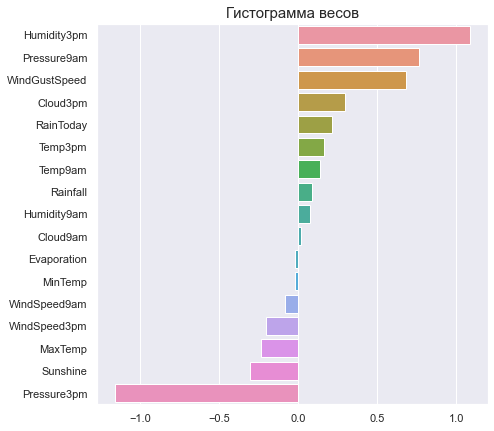

In [53]:
plt.figure(figsize=(7, 7))
sorted_weights = sorted(zip(model.coef_[0], numeric_features), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
_ = sns.barplot(y=features, x=weights).set_title("Гистограмма весов", size=15)

**Вопрос 14** ($1$ балл): Почему даже после нормализации график не до конца похож на гистограмму корреляций?

Ответ: Корреляция говорит только о возможной зависимости, но не о её наличии, поэтому некоторые величины могут сильно коррелировать, но при этом не быть зависимыми.  
Также стоит отметить, что некоторые признаки по отдельности могут не сильно корреляировать с целевой переменной, но их линейная комбинация может вносить значительной вклад, например, если сегодня утром и вечером высокое давление, то дождя может и не быть, а вот если давление было низким, а потом резко возросло, то это может свидетельствовать о приближающемся дожде.

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это C — коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем alpha по логарифмической сетке, чтобы узнать оптимальный порядок величины).

**Вопрос 15** ($1$ балл): Чем отличаются валидационная и тестовая выборки?

Валидационная выборка — выборка, которая используется для подбора параметров, выбора признаков и принятия других решений, касающихся обучения алгоритма, а тестовая выборка — выборка, которая используется для оценки качества работы алгоритма, при этом никак не используется для обучения алгоритма или подбора используемых при обучении параметров.

Best C = 38.8816


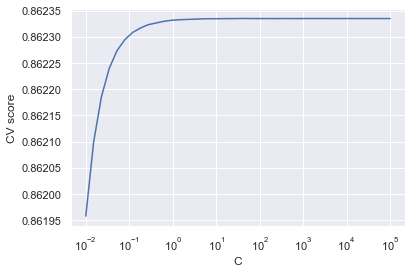

In [54]:
from sklearn.model_selection import GridSearchCV

C = np.logspace(-2, 5, 40)
searcher = GridSearchCV(LogisticRegression(solver='lbfgs'), [{"C": C}], scoring="roc_auc", cv=10)
searcher.fit(X_train_scaled, y_train)

best_C = searcher.best_params_["C"]

print("Best C = %.4f" % best_C)

_ = plt.plot(C, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")
plt.show()

**Вопрос 16** ($0.5$ балла): Почему с ростом $C$ качество не падает, хотя модель должна недообучаться?

С ростом С альфа уменьшается, так как альфа обратно пропорциональна С. При очень больших значениях C это может привести к фактическому отсутствию регуляризации и переобучению. Видимо, модель и без регуляризации справилась.

**Вопрос 17** ($1$ балл): Почему мы не подбираем коэффициент регуляризации $C$ по обучающей выборке (кросс-валидация не считается, потому что там мы обучающую выборку тоже разбиваем на train и val, но несколько раз)? По тестовой выборке?

Ответ: Параметры не подбираются на тестовой выборке, так как таким образом можно выбрать параметры, которые лучше всего подходят к тестовой выборке, то есть немного переобучиться на тесте. Тестовая выборка делается для того, чтобы объективно оценить качество модели на данных, которые не используются в обучении и подборе параметров. 
На обучающей выборке параметры не подбираются, так как оценка качества обучения скорее всего будет неверной: модель может переобучиться и дать очень хорошие результаты с параметром, который в итоге на тестовой выборке даст плохой результат.

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся удобным классом Pipeline: обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод fit, а для тестовой — transform), а затем обучить/применить модель (для обучающей fit, а для тестовой — predict)). Pipeline позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую. Однако, если ваши модели не укладываются в использование простых fit, transform и predict, то этот класс вам не подойдёт

In [55]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('classification', LogisticRegression(solver='lbfgs', C=best_C))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict_proba(X_test[numeric_features])[:, 0]
print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))

Test logloss = 2.1803
Test roc auc score = 0.7193


**Вопрос 18** ($1$ балл): Почему качество не выросло?

Ответ: при достаточно больших значениях С коэффициент альфа близок к 0, то есть регуляризации практически нет. Результаты для модели без регуляризации (код ниже) совпадают с результатами, полученными для лучшего С, следовательно, в данном случае регуляризация не нужна совсем.

In [56]:
simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('classification', LogisticRegression(penalty='none', solver='lbfgs'))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict_proba(X_test[numeric_features])[:, 0]

print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))

Test logloss = 2.1803
Test roc auc score = 0.7193


Рассмотрим теперь категориальные признаки. Сразу отметим, что признак "Date" очень опасен, и лучше пока его выкинуть. Это связано с тем, что мы можем получить прямую о том, будет ли завтра дождь, если текущее место и завтрашняя дата встречались где-то в обучающей выборке. Очень часто также встречаются признак наподобие "ID", которые могут содержать аналогичные утечки информации. С такими признаками всегда нужно обращаться осторожно!

In [57]:
categorical = list(X_train.drop(columns=["Date"]).dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

Для работы с категориальными признаками нужно их как-то закодировать числами. Для этого нам понадобится заранее реализованный class MyOneHotEncoder. Вообще OneHotEncoding &mdash; самая стандартная процедура для кодирования категориальных признаков. Помимо библиотеки sklearn, встроенный OneHotEncoder есть в библиотеке pandas и называется get_dummies. Однако сегодня мы не будем пользоваться библиотечными методами:)

Если последующий код выполнятеся слишком медленно, то вероятно Вы реализовали MyOneHotEncoder без использования векторных операций из библиотеки numpy. Попробуйте метод numpy.vectorize

In [58]:
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', MyOneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('classification', LogisticRegression(solver='lbfgs', max_iter=200))
])

model = pipeline.fit(X_train.drop(columns=["Date"]), y_train)
y_pred = model.predict_proba(X_test.drop(columns=["Date"]))[:, 0]
print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))

Test logloss = 2.2765
Test roc auc score = 0.7290


Качество немного выросло, если смотреть на ROC AUC!

Давайте попробуем счётчики.

Напомним, что счётчики преобразуют категориальный признак в три значения:

1. Доля successes объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.  $$\begin{align}
successes = \frac{\sum_{k=1}^{n_{objects}} y_k \mathbb{I}[x^{i}_k = a_j]}{\sum_{k=1}^{n_{objects}} \mathbb{I}[x^{i}_k = a_j]}
\end{align}$$
2. Доля counts объектов в обучающей выборке с таким же значением признака. $$\begin{align}
counters = \frac{\sum_{k=1}^{n_{objects}} \mathbb{I}[x^{i}_k = a_j]}{n_{objects}}
\end{align}$$
2. Сглаженное отношение двух предыдущих величин: $$\begin{align}
relation = \frac{successes + a}{counters + b},~a \geq 0,~b \geq 0
\end{align}$$

Здесь $\mathbb{I}$ &mdash; индикаторная функция: $\mathbb{I}[\zeta] = 1$, если выражение $\zeta$ истинно, и $\mathbb{I}[\zeta] = 0$, если выражение $\zeta$ ложно.

In [59]:
scal = StandardScaler()

enc_train = FoldCounters()
enc_train.fit(X_train[categorical], y_train.to_numpy())
X_train_counters = enc_train.transform(X_train[categorical])

enc_test = SimpleCounterEncoder()
enc_test.fit(X_train[categorical], y_train)
X_test_counters = enc_test.transform(X_test[categorical])

X_train_preprocessed = scal.fit_transform(np.hstack((X_train[numeric_features].to_numpy(), X_train_counters)))
X_test_preprocessed = scal.transform(np.hstack((X_test[numeric_features].to_numpy(), X_test_counters)))

model = LogisticRegression(solver="lbfgs")
model.fit(X_train_preprocessed, y_train)

y_pred = model.predict_proba(X_test_preprocessed)[:, 0]
print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))

Test logloss = 2.2006
Test roc auc score = 0.7209


**Вопрос 19** ($1$ балл): Счётчики показывают худшее качество по AUC ROC, нежели OneHotEncoding. В чём же преимущества счётчиков?

Счётчики могут давать лучшие результаты, если данные содержат признаки с разнообразными частотами категорий, но в условиях, когда частоты всех категорий примерно одинаковые, такое кодирование проигрывает OneHotEncoding.

**Вопрос 20** (1 балл): Можно ли использовать $l_1$ регуляризацию в логистической регрессии?

Можно, но не со всеми алгоритмами (только ‘liblinear’ и ‘saga’).

**Выводы** Итак, мы научились, применять линейные модели для задач классификации и регрессии. Узнали зачем нужна регуляризация, а также научились преобразовывать входные данные для ускорения обучения линейных моделей, и повышения их качества.

А теперь перезапустите ноутбук: Kernel -> Restart & Run All